Import the required librarires

In [954]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
df=pd.read_csv("C:/Users/USER/Desktop/cars_data.csv")
df.shape[0]


7777

We have 7777 rows of data that contain a lot of columns that are totally useless because all of its columns are NaN so we need to drop them

Drop All the rows that all of its data are NaN , After that we have reached to 6864 data rows instead of 7777 

In [955]:
df=df.dropna(how='all')

In [956]:
df.isna().any()
percentage_of_missing_data=df.isna().sum()/df.shape[0]
percentage_of_missing_data


Price           0.000000
Model           0.000000
Year            0.000000
لون السيارة     0.000000
نوع الوقود      0.000000
أصل السيارة     0.000000
رخصة السيارة    0.000000
نوع الجير       0.000000
الزجاج          0.000000
قوة الماتور     0.000000
عداد السيارة    0.282780
عدد الركاب      0.113199
وسيلة الدفع     0.000000
معروضة          0.000000
أصحاب سابقون    0.240385
إضافات          0.072990
dtype: float64

Printing the Percentage of the missing data 


We have now FOUR features with missing values :
عداد السيارة, عدد الركاب , اصحاب سابقون ,اضافات

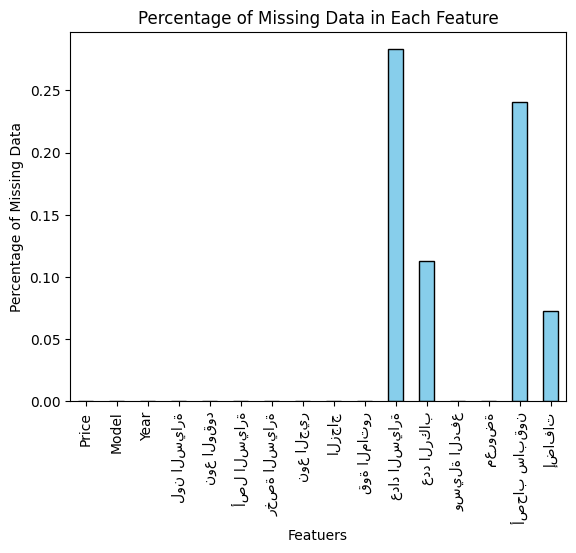

In [957]:
percentage_of_missing_data=df.isna().sum()/df.shape[0]
percentage_of_missing_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Featuers')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data in Each Feature')

plt.show()

First start with the features number of seats, we need first to convert the data to numerical one and then fill the missing data with KNN


In [958]:
df["عداد السيارة"].value_counts()

عداد السيارة
100000            107
200000            103
50000              75
00000              73
75000              69
                 ... 
203000كيلو متر      1
148372              1
0 صفر كيلو          1
40300               1
7686866             1
Name: count, Length: 1224, dtype: int64

In [959]:
import re

def convert_to_numeric(data):
    numbers = re.findall(r'\d+', str(data))   
    return sum(map(int, numbers)) if numbers else np.nan

df['عدد الركاب'] = df['عدد الركاب'].apply(convert_to_numeric)


Drop all the additions for the car except for "فتحة السقف" and turn binarize it 

In [960]:
df["إضافات"]=df["إضافات"].fillna("")
df["فتحة سقف"]=df["إضافات"].apply(lambda x: 1 if "فتحة سقف" in x else 0)
df=df.drop(columns=["إضافات"])


Dropping the "معروضة" column

In [961]:
df=df.drop(columns=["معروضة", "وسيلة الدفع"])


Turning the data type of the price into number (fix a bug in the data extraction code)


In [962]:
df["Price"] = df["Price"].apply(lambda x: ast.literal_eval(x)[0] if pd.notna(x) else x)
df["Price"] = pd.to_numeric(df["Price"], errors='coerce')



cleaning the noisy data in the model feature and split it into to features : brand and model of the car

In [963]:
for index, row in df.iterrows():
    if "بي ام دبليو" in row['Model']:
        df.at[index, 'car_brand'] = "BMW"
        df.at[index, 'car_model'] = row['Model'].replace("بي ام دبليو", '').strip()
        
    elif "جي ام سي" in row['Model']:
        df.at[index, 'car_brand'] = "GMC"
        df.at[index, 'car_model'] = row['Model'].replace("جي ام سي", '').strip()

    elif "الفا روميو" in row['Model']:
        df.at[index,'car_brand']="الفا روميو"
        df.at[index, 'car_model'] = row['Model'].replace("الفا روميو", '').strip()

    elif "رانج" in row['Model']:
        df.at[index,'car_brand']="لاندروفر"
        df.at[index, 'car_model'] ="رينج روفر"

    else:
        brand, model = row['Model'].split(maxsplit=1)
        df.at[index, 'car_brand'] = brand
        df.at[index, 'car_model'] = model

df['car_model'] = df['car_model'].apply(lambda x: x.replace('BMW', '').strip() if pd.notna(x) else x)
df['car_model'] = df['car_model'].apply(lambda x: x.replace('ام سي ', '').strip() if pd.notna(x) else x)


C:\Users\USER\AppData\Local\Temp\ipykernel_11856\426595950.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'كيا' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'car_brand'] = brand
C:\Users\USER\AppData\Local\Temp\ipykernel_11856\426595950.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'اوبتيما' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'car_model'] = model


In [964]:
df["car_brand"].unique()

array(['كيا', 'هونداي', 'فيات', 'بيجو', 'BMW', 'اوبل', 'مرسيدس', 'فورد',
       'نيسان', 'سكودا', 'فولكسفاجن', 'هوندا', 'دايو', 'شفروليه', 'رينو',
       'جييب', 'دراجة', 'ستروين', 'فولفو', 'مازدا', 'ايسوزو', 'سانغ',
       'سيت', 'تويوتا', 'سوبارو', 'ميتسوبيشي', 'اودي', 'شاحنة', 'داف',
       'سوزوكي', 'داتشيا', 'GMC', 'كاديلاك', 'لاندروفر', 'روفر', 'باص',
       'أفيكو', 'Dodge', 'ديهاتسو', 'الفا روميو', 'جاجوار'], dtype=object)

Dropping the Model feature

In [965]:
df=df.drop(columns="Model")


Translating the feature names into english

In [966]:
df.rename(columns={'لون السيارة': 'color',
                    'نوع الوقود': 'gas_type',
                      'نوع الجير': 'gear_type',
                      'رخصة السيارة':"car_license",
                      'أصل السيارة':"car_origin",
                      "الزجاج":"car_glass_type",
                      "قوة الماتور":"engine_power",
                      "عداد السيارة":"odometer",
                      "عدد الركاب":"seating_capacity",
                      "أصحاب سابقون":"number_of_owners",
                      "فتحة سقف":"sunroof",




                        }, inplace=True)


Filling the missing data of the feature seating_capacity with the most frequent value which

In [967]:
most_frequant_values=df["seating_capacity"].value_counts() ##prints out 5
df["seating_capacity"].fillna(5,inplace=True)
#df["seating_capacity"].value_counts()  


Dropping the number_of_owners feature from the prototype

In [968]:
df.drop(columns="number_of_owners",inplace=True)


Filling the feature "odometer" with the mean of the training data

In [969]:
df["odometer"] = pd.to_numeric(df["odometer"].replace('None', pd.NA).str.extract('(\d+)', expand=False), errors='coerce')
df["odometer"] = df["odometer"].apply(lambda x: x * 1000 if pd.notna(x) and x < 1000 else x)
df = df.drop(df[(df["odometer"] <= 10000) & (df["odometer"] >= 1000)].index)
df = df[df['odometer'].notna()]
df["odometer"]

0         75000.0
3        130000.0
7         38000.0
10        50000.0
14        56000.0
          ...    
7771     130000.0
7772          0.0
7773      50000.0
7774     100000.0
7776    7686866.0
Name: odometer, Length: 4170, dtype: float64

In [970]:
df.isna().sum()

Price               0
Year                0
color               0
gas_type            0
car_origin          0
car_license         0
gear_type           0
car_glass_type      0
engine_power        0
odometer            0
seating_capacity    0
sunroof             0
car_brand           0
car_model           0
dtype: int64

In [971]:
df.dtypes

Price                 int64
Year                float64
color                object
gas_type             object
car_origin           object
car_license          object
gear_type            object
car_glass_type       object
engine_power        float64
odometer            float64
seating_capacity    float64
sunroof               int64
car_brand            object
car_model            object
dtype: object

The Data plot before dropping the oultiers

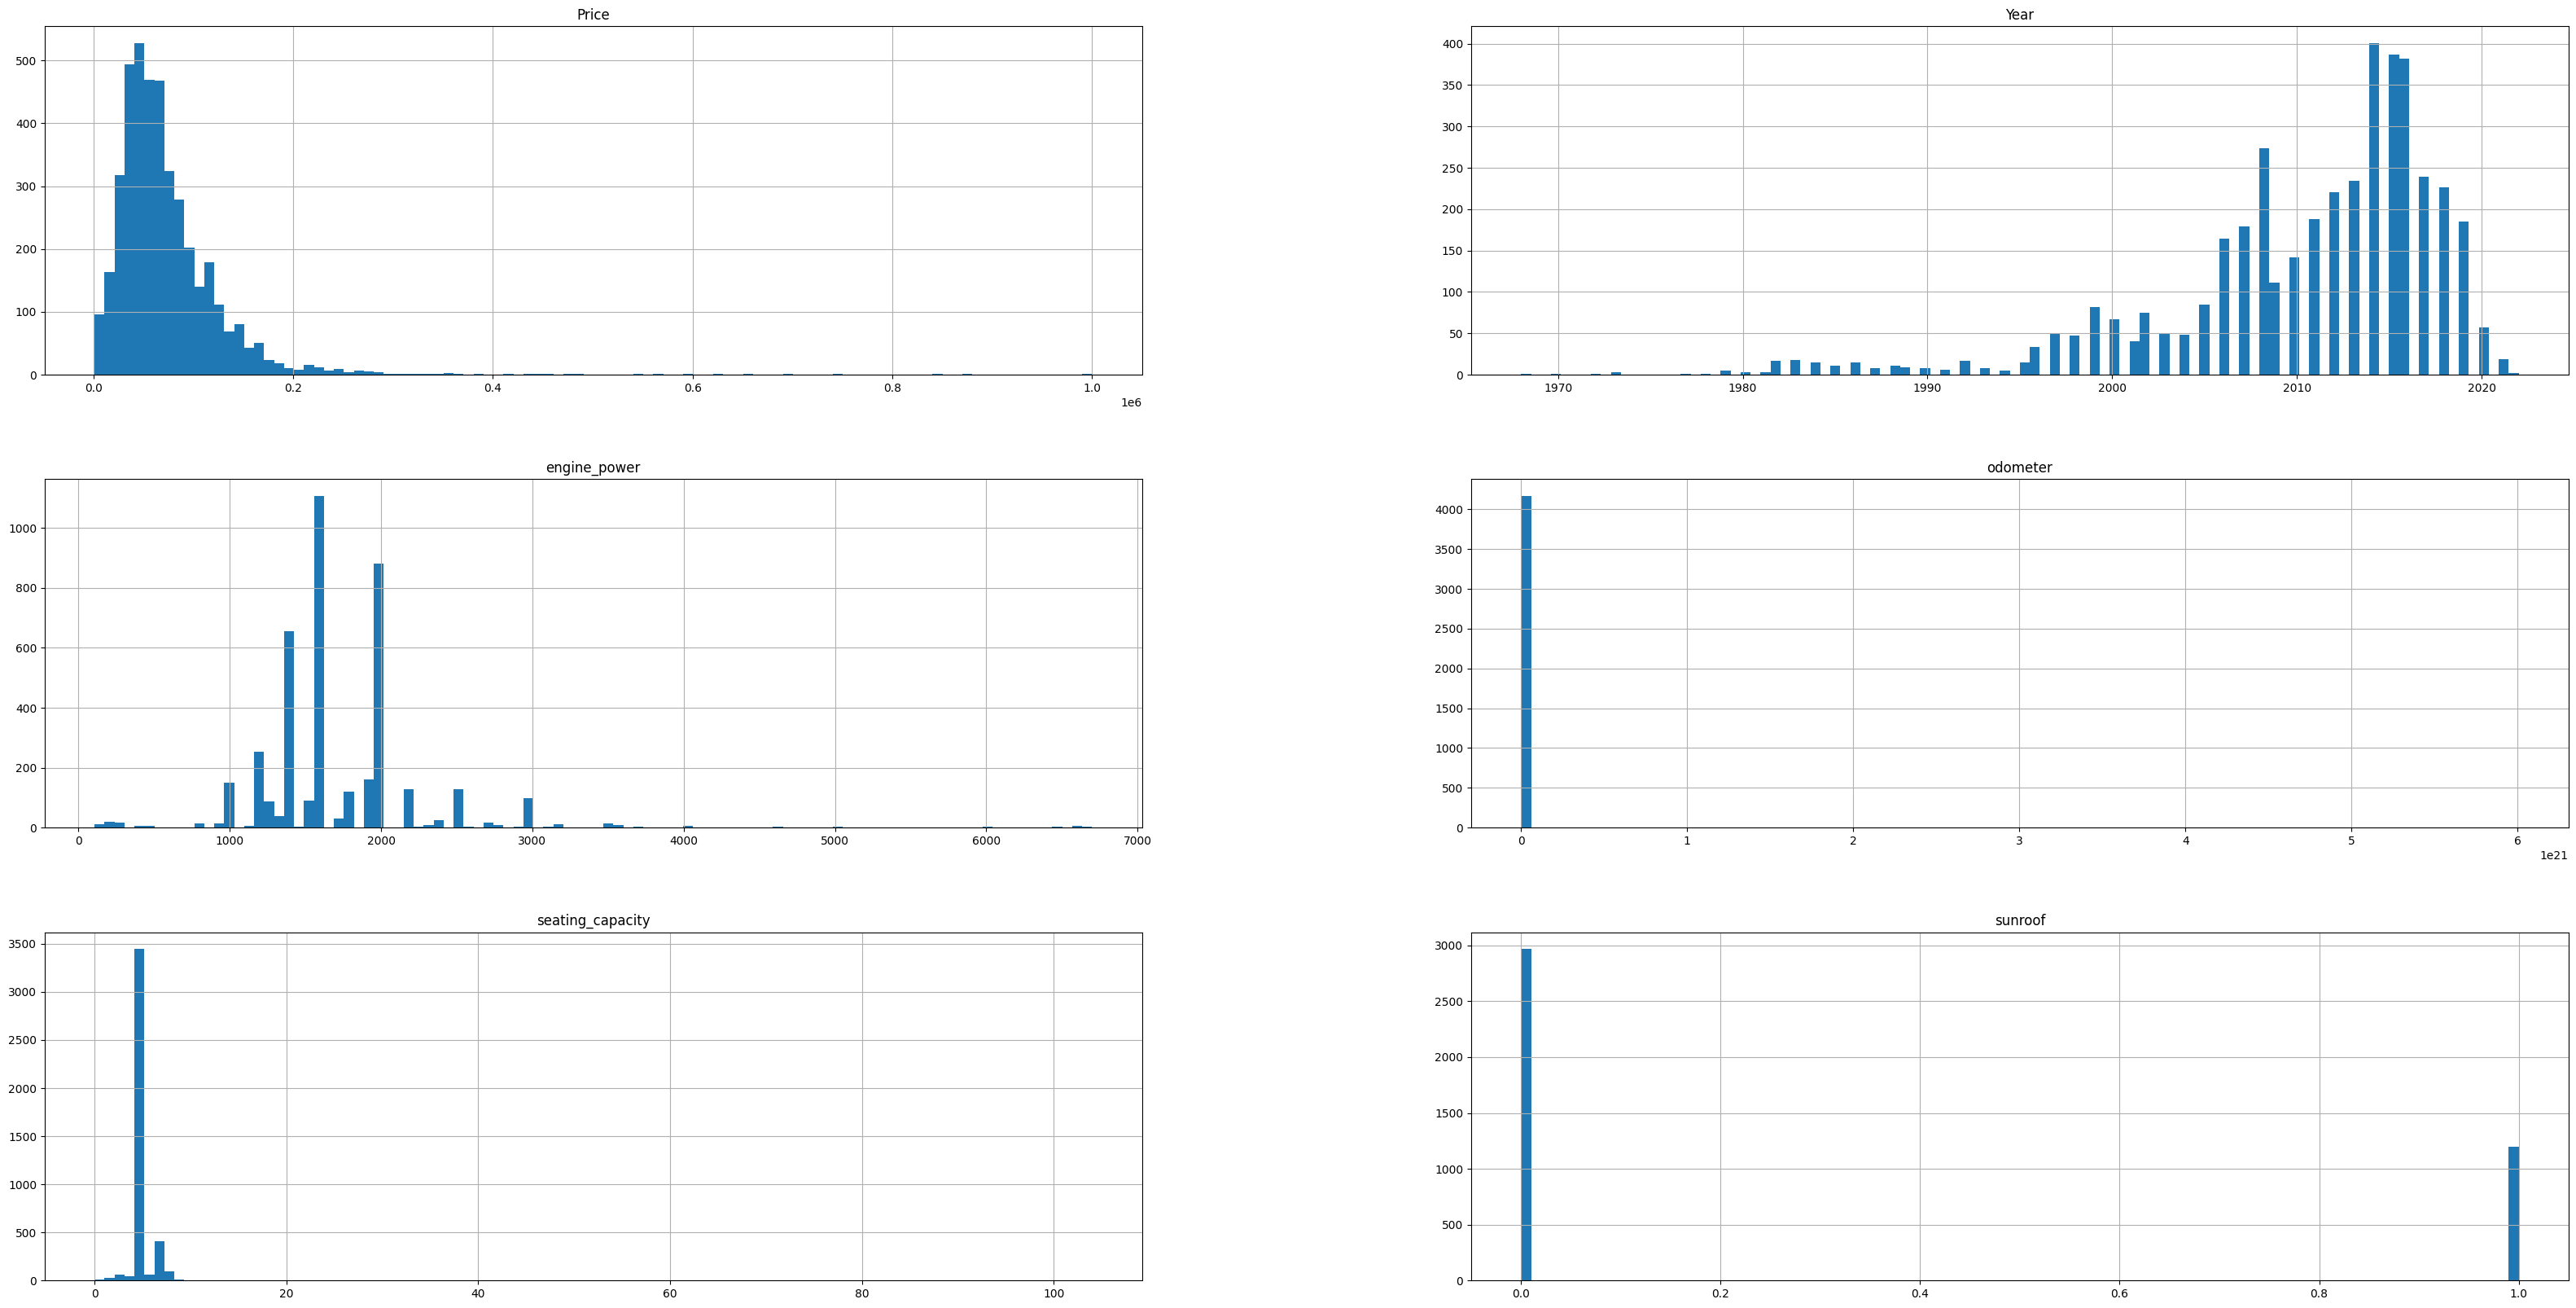

In [972]:
df.hist(bins=100,figsize=(40,20))
plt.show()

dropping the outliers of the data frame

In [973]:
z_scores = zscore(df.select_dtypes(include='number'))
threshold = 3.0
outlier_mask = (abs(z_scores) > threshold).any(axis=1)
df = df[~outlier_mask]
df

,Price,Year,color,gas_type,car_origin,car_license,gear_type,car_glass_type,engine_power,odometer,seating_capacity,sunroof,car_brand,car_model
0,100000,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000.0,5.0,1,كيا,اوبتيما
3,60000,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000.0,8.0,1,كيا,سورينتو
7,54000,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000.0,5.0,0,بيجو,208
10,230000,2014.0,أبيض,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,50000.0,5.0,1,مرسيدس,C200
15,75000,2005.0,أبيض عاجي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,2500.0,460000.0,8.0,0,فورد,ترانزيت
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,45000,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000.0,5.0,0,كيا,مورننغ
7772,48000,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,0.0,8.0,0,فورد,ترانزيت
7773,87000,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000.0,5.0,0,بيجو,بارتنر
7774,126000,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100000.0,7.0,1,كيا,سورينتو


the data plot after dropping the outliers

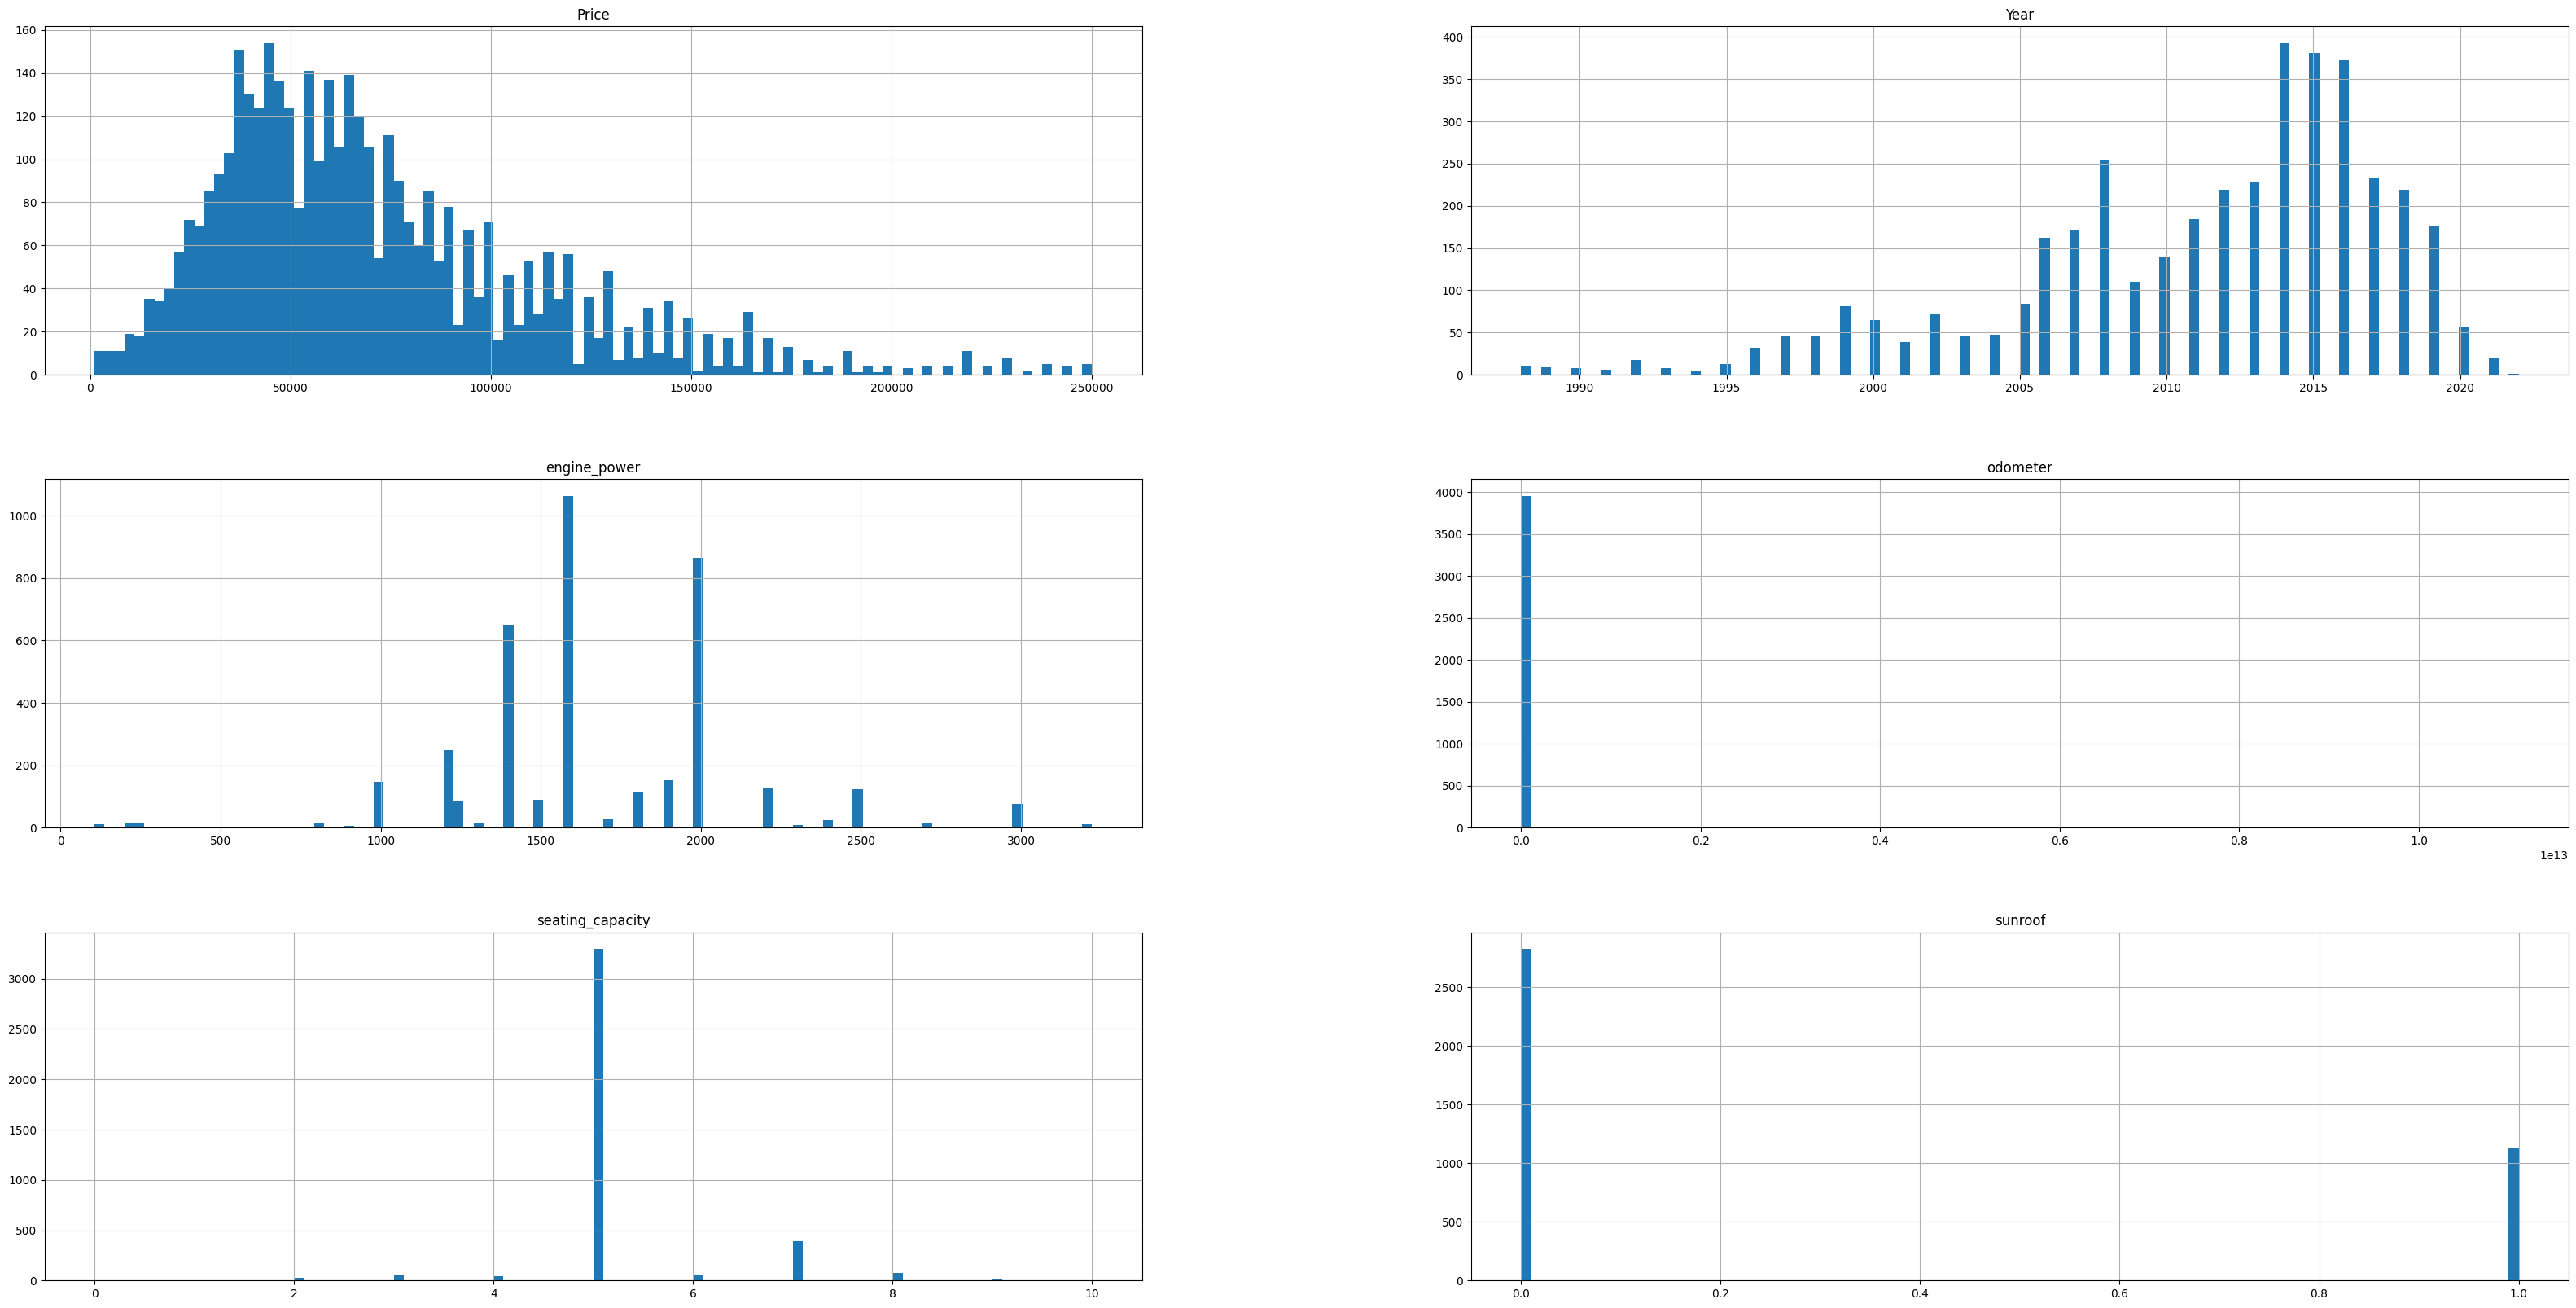

In [974]:
df.hist(bins=100,figsize=(40,20))
plt.show()

Convert all the data into numeric

In [975]:
X=df.drop("Price",axis=1)
y=df["Price"]
data_to_be_converted=["car_model","car_brand","gas_type","color","car_license","gear_type","car_glass_type","car_origin"]
one_hot=OneHotEncoder()
transformer=ColumnTransformer([("one_hot",
                                one_hot,
                                data_to_be_converted)],
                                remainder="passthrough")

transformered_X=transformer.fit_transform(X)
transformered_X


<3957x477 sparse matrix of type '<class 'numpy.float64'>'
	with 48269 stored elements in Compressed Sparse Row format>

In [976]:
x_train, x_test,y_train,y_test=train_test_split(transformered_X,y,test_size=0.2)


KNN Regression 

In [977]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(x_train,y_train)
model.score(x_test,y_test)


0.021464646464646464

Decesion Tree

In [978]:
model=DecisionTreeClassifier()
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.04924242424242424